# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Откроем датасет 

In [554]:
try:
    open('~/python/datasets/real_estate_data.csv')
    dataset = '~/python/datasets/real_estate_data.csv'
except:
    open('/datasets/real_estate_data.csv')
    dataset = '/datasets/real_estate_data.csv'

In [555]:
#Посмотрим на файл с данными:
with open(dataset, 'r') as file:
    for i in range(5):
        print(file.readline())
file.close()

total_images	last_price	total_area	first_day_exposition	rooms	ceiling_height	floors_total	living_area	floor	is_apartment	studio	open_plan	kitchen_area	balcony	locality_name	airports_nearest	cityCenters_nearest	parks_around3000	parks_nearest	ponds_around3000	ponds_nearest	days_exposition

20	13000000.0	108.0	2019-03-07T00:00:00	3	2.7	16.0	51.0	8		False	False	25.0		Санкт-Петербург	18863.0	16028.0	1.0	482.0	2.0	755.0	

7	3350000.0	40.4	2018-12-04T00:00:00	1		11.0	18.6	1		False	False	11.0	2.0	посёлок Шушары	12817.0	18603.0	0.0		0.0		81.0

10	5196000.0	56.0	2015-08-20T00:00:00	2		5.0	34.3	4		False	False	8.3	0.0	Санкт-Петербург	21741.0	13933.0	1.0	90.0	2.0	574.0	558.0

0	64900000.0	159.0	2015-07-24T00:00:00	3		14.0		9		False	False		0.0	Санкт-Петербург	28098.0	6800.0	2.0	84.0	3.0	234.0	424.0



Разделителем в датасете, по-видимому, является символ табуляции '/t'

#### Загрузим данные из файла в датафрейм

In [556]:
#Импортируем библиотеки:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
#Попросим панду не показывать нам тип данных float в экспоненциальном режиме:
pd.options.display.float_format = '{:.2f}'.format

In [557]:
#Откроем файл с данными как датафрейм:
df = pd.read_csv(dataset, sep='\t')

#### Изучим общую информацию о полученном датафрейме

In [558]:
#Посмотрим полную информацию датафрейма:  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [559]:
#Исправим стилистическую ошибку: оформим название столбца 'cityCenters_nearest' в "змеином_стиле":
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

In [560]:
#Посмотрим, как выглядят данные в датафрейме:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


#### Построим общую гистограмму для всех числовых столбцов датафрейма

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'city_centers_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], 

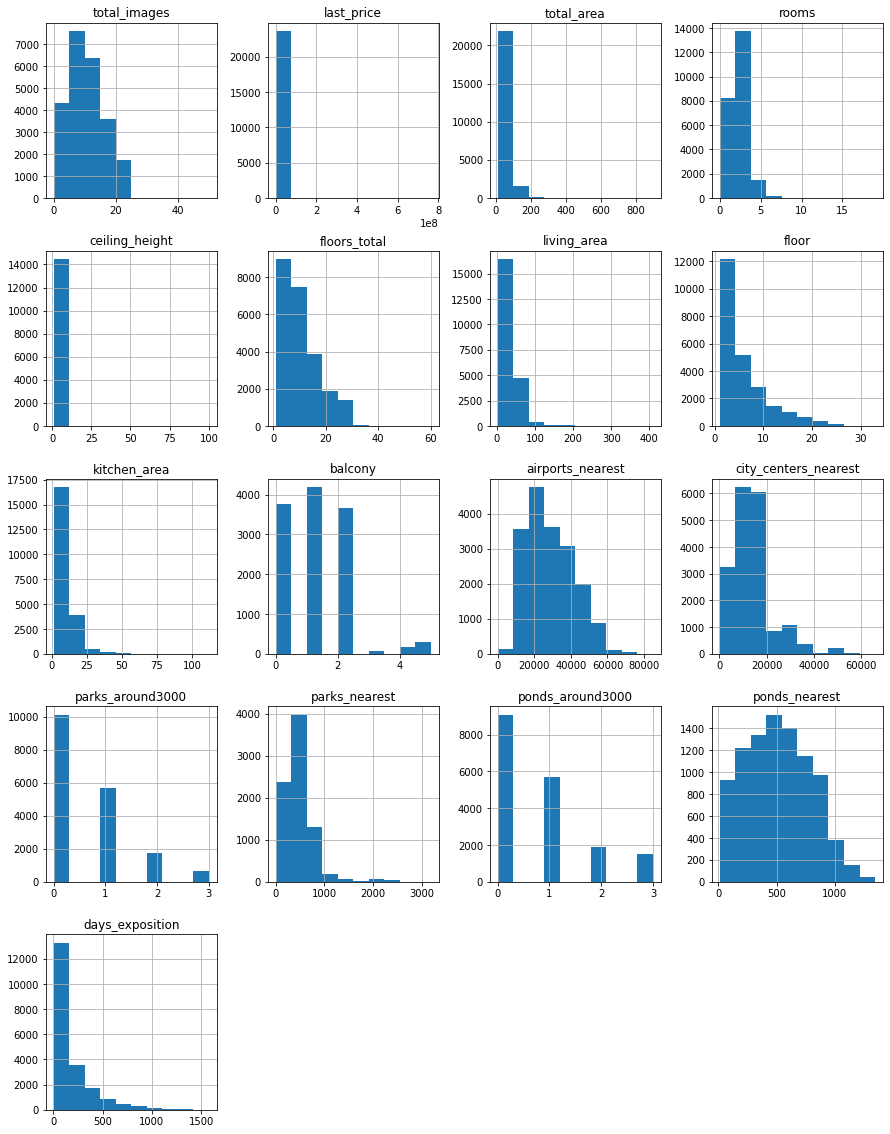

In [561]:
df.hist(figsize=(15,20))

#### Оценим допустимый объем потерь датасета

In [562]:
#Посмотрим краткую информацию датафрейма:
df.shape

(23699, 22)

В датафрейме 23.7 тыс. записей

На этапе предобработки данных нам прийдется избавляться от части строк датасета (выбросы, неполные и недостоверные данные и т.п.). Какой объем данных нам не принципиально будет потерять? В масштабе 23.7 тыс. записей я оцениваю некритичную потерю данных в несколько сотен записей. Чтобы определить это число более строго, я скажу, что:
- потеря 2% от числа всех записей несущественно повлияет на результаты ананлиза;
- и даже потеря 5% будет вполне приемлима;
- тогда как потеря 10% и более способна исказить результаты анализа.

In [563]:
for i in [2,5,10]:
    print(i, '% это', int(len(df)*i/100),'строк датафрейма.\n')

2 % это 473 строк датафрейма.

5 % это 1184 строк датафрейма.

10 % это 2369 строк датафрейма.



Запомним эти цифры, возможно мы еще будем обращаться к ним в процессе исследования.

In [564]:
# Напишем небольшую функцию для оценки величины потеряных данных:
def checklost(lost):
    if lost <= 473:
        return print("Это несущественно\n")
    elif lost <= 1184:
        return print("Это приемлимо\n")
    elif lost <= 2369:
        return print("Это серьёзно\n")
    else:
        return print("Затрудняюсь ответить((\n")

### Предобработка данных

#### Работа с пропусками

##### Определим, в каких столбцах есть пропуски

In [565]:
#Посмотрим, в каких столбцах датафрейма есть пропуски и оценим их количество, абсолютное и относительное:
n = 0
for column in df.columns:
    if df[column].isna().sum() > 0:
        na = df[column].isna().sum()
        print('%-25s %-20s %-20.3f' % (df.columns[n], f'isna() {na}', (100*na/len(df))))
    n += 1

ceiling_height            isna() 9195          38.799              
floors_total              isna() 86            0.363               
living_area               isna() 1903          8.030               
is_apartment              isna() 20924         88.291              
kitchen_area              isna() 2278          9.612               
balcony                   isna() 11519         48.605              
locality_name             isna() 49            0.207               
airports_nearest          isna() 5542          23.385              
city_centers_nearest      isna() 5519          23.288              
parks_around3000          isna() 5518          23.284              
parks_nearest             isna() 15620         65.910              
ponds_around3000          isna() 5518          23.284              
ponds_nearest             isna() 14589         61.560              
days_exposition           isna() 3181          13.423              


##### Заполним пропущенные значения там, где это возможно

###### Столбец `balcony`

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет.
Такие пропуски правильно заменить на 0:

In [566]:
df['balcony'] = df['balcony'].fillna(0)

###### Столбец `is_apartment`

Все продавцы коммерческой недвижимости, являющиеся профучастниками на этом рынке, мотивированы как можно полнее описать в объявлении продаваемый объект. Поэтому, там где стоит "True" сомневаться не приходится.

Однако, в частных объявлениях не все продавцы понимают различие между "апартаментами" и обычной квартирой, поэтому, скорее всего, в частных объявлениях это поле остается просто незаполненным.

Заполним все пропуски значениями False по умолчанию.

In [567]:
df['is_apartment'] = df['is_apartment'].fillna(False)

###### Столбец `kitchen_area`

Логично предположить, что в объявлениях часто не указывают площадь кухни, если она не выделена в отдельную комнату: в квартирах со свободной планировкой и в квартирах-студиях.
Площадь кухни в этом случае входит в состав общей жилой площади.

In [568]:
df['kitchen_area'].where((df['kitchen_area'].isna()) & (df['studio']),0)
df['kitchen_area'].where((df['kitchen_area'].isna()) & (df['open_plan']),0)

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
23694   0.00
23695   0.00
23696   0.00
23697   0.00
23698   0.00
Name: kitchen_area, Length: 23699, dtype: float64

###### Столбец `living_area` , оставшиеся пропуски в  столбце `kitchen_area` 

В некоторых объявлениях продавцы указали общую площадь объекта недвижимости, но не указали ее распределение на жилую/нежилую, и площадь кухни. Для таких объявлений мы заполним отсутствующую информацию медианными значениями, через коэфициент, отражающий медианную долю кухни/жилой площади в общей площади квартиры.

In [569]:
#К-т доли жилой площади в общей площади квартиры (рассчитанный по медианным значениям):
k_median_living_area = df['living_area'].median() / df['total_area'].median()
#К-т доли площади кухни в общей площади квартиры (рассчитанный по медианным значениям):
k_median_kitchen_area = df['kitchen_area'].median() / df['total_area'].median()

Применим полученные коэфициенты, чтобы заполнить пропуски.

In [570]:
df['living_area'] = df['living_area'].fillna(k_median_living_area*df['total_area'])
df['kitchen_area'] = df['kitchen_area'].fillna(k_median_kitchen_area*df['total_area'])

###### Столбец `ceiling_height`

Аналогичным образом поступим с пропусками информации о высоте потолков. Многие продавцы, видимо, сочли эту информацию не важной, и около 1 /3 всех объявлений не содержат этой информации. Заполним пропуски в этом поле медианными значениями для каждого значения этажности по информации из нашего датасета.

In [571]:
#Создадим переменную floors, которая будет содержать перечень всех значений этажности:
floors = df['floors_total'][~df['floors_total'].isna()].astype('int').unique()
#Пройдем циклом for по каждому значению этажности,
#присваивая отсутствующим значениям медианное значение,
#рассчитанное для данного типа этажности:
for floor in floors:
    median_ceiling_height = df['ceiling_height'][df['floors_total']==floor].median()
    df['ceiling_height'][(df['floors_total']==floor)&(df['ceiling_height'].isna())] = median_ceiling_height

/tmp/ipykernel_32/2778907507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ceiling_height'][(df['floors_total']==floor)&(df['ceiling_height'].isna())] = median_ceiling_height
/tmp/ipykernel_32/2778907507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ceiling_height'][(df['floors_total']==floor)&(df['ceiling_height'].isna())] = median_ceiling_height
/tmp/ipykernel_32/2778907507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

##### Удаление строк с неполными данными

В некоторых случаях, мы имеем строки с неполными данными. Когда таких строк в датафрейме не очень много и они не оказывают существенного влияния на результаты исследования, их проще удалить, чем пытаться исправить.

Например, некоторые респонденты не заполнили информацию о квартире, которая представляет для нашего исследования существенный интерес: высоту потолков в квартире, площадь кухни, количество этажей в доме и т.п.
Такие строки малоинформативны и не представляют особого интереса.

В то же время, некоторая информация в этих строках вполне возможно нам еще пригодится (например, для расчета средних или медианных значений, для рассчета доли категориальных показателей и т.п.) Поэтому, на данном этапе, такие строки будут только "помечены на удаление", а удалены позже, непосредственно перед этапом исследовательского анализа данных.

In [572]:
#Создадим список `bad_indexes`. В него мы будем записывать индексы строк исходного датафрейма, которые впоследствии удалим.
bad_indexes = []
#Для этого мы будем использовать конструкцию:
#bad_indexes.extend(df.index)

###### Столбец `locality_name`

Информация о местонахождении объекта недвижимости - одна из ключевых. Но в 49 записях она пропущена, и восстановить ее из других источников не представляется возможным. Такие записи проще всего удалить.

In [573]:
bad_indexes.extend(df['locality_name'].loc[df['locality_name'].isna()].index)

###### Строки с пропусками в нескольких столбцах

Записей с пропусками в столбце `floors_total` немного, всего 86. В то же время, даже при беглом взгляд на них видно, что пропусками в одном столбце дело не ограничивается:

In [574]:
df.loc[df['floors_total'].isna()].head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.00,65.20,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,False,...,12.00,0.00,Санкт-Петербург,39197.00,12373.00,1.00,123.00,0.00,NaN,49.00
237,4,2438033.00,28.10,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,...,4.92,0.00,Санкт-Петербург,22041.00,17369.00,0.00,NaN,1.00,374.00,251.00
457,4,9788348.00,70.80,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,False,...,10.63,0.00,Санкт-Петербург,37364.00,8322.00,2.00,309.00,2.00,706.00,727.00
671,4,6051191.00,93.60,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,False,...,16.80,0.00,Санкт-Петербург,22041.00,17369.00,0.00,NaN,1.00,374.00,123.00
1757,5,3600000.00,39.00,2017-04-22T00:00:00,1,NaN,NaN,22.50,9,False,...,6.82,0.00,Санкт-Петербург,22735.00,11618.00,1.00,835.00,1.00,652.00,77.00


Посмотрим, а сколько среди них записей, в которых пропущено сразу несколько ключевых характеристик объекта недвижимости?

In [575]:
len(df['floors_total'].loc[((df['floors_total'].isna())&
            (df['ceiling_height'].isna())&
            (df['kitchen_area'].isna()))])

0

In [576]:
# Добавим и эти записи к списку "на удаление":
bad_indexes.extend(df['floors_total'].loc[(
            (df['floors_total'].isna())&
            (df['ceiling_height'].isna())&
            (df['kitchen_area'].isna())&
            (df['is_apartment'].isna())
                                         )].index)

In [577]:
#проверим работу функции.
#Как повлияет удаление помеченных нами строк на результатах анализа?
print('Помечено "на удаление" строк:', len(pd.Series(bad_indexes).unique()))
checklost(len(pd.Series(bad_indexes).unique()))


Помечено "на удаление" строк: 49
Это несущественно



###### Столбец `floors_total`

Подумав немного, я решил что пропусков в floors_total не слишком много, и не так уж страшно потерять ещё 0.4% датасета

In [578]:
bad_indexes.extend(df['floors_total'].loc[df['floors_total'].isna()].index)

##### Cтолбцы с неполными данными оставленные без изменений

###### Столбец `days_exposition`

В столбце `days_exposition`указано количество дней, в течении которых было размещено объявление (от публикации до снятия).

Скорее всего, отсутствие данных в этом столбце означает, что данный показатель не может быть рассчитан, поскольку объявление о продаже еще не снято.

###### Столбцы с пропусками данных геолокации

В нескольких столбцах с данными геолокации обращает на себя внимание повторяющаяся цифра, начинающаяся с 55хх. Скорее всего, по некоторым строкам данные геолокации отсутствуют одновременно в нескольких столбцах. Брать такие строки для анализа географического расположения объекта недвижимости будет нельзя. Проверим, так ли это?

In [579]:
len(df['locality_name'].loc[((df['parks_around3000'].isna())&
            (df['parks_nearest'].isna())&
            (df['ponds_around3000'].isna())&
            (df['ponds_nearest'].isna())&
            (df['city_centers_nearest'].isna())&
            (df['airports_nearest'].isna()))])

5518

Действительно, по 5518 строкам данные геолокации отсутствуют полностью. Возможно, из-за технической ошибки при наполнении датасета, или из-за отсутствия технической возможности определения геолокации объекта недвижимости - точно этого мы уже никогда не узнаем.

Удалить 5,5 тыс. записей (а это около 20%)? Это значительная часть, и риск потерять значимую информацию слишком велик.

Эти строки можно было бы заполнить какой-нибудь заглушкой, типа "Данные отсутствуют", но тогда мы будем иметь в столбцах с данными геолокации значения различного типа (float и str), что может привести к проблемам при применении к этим столбцам математических методов. В то время как пропуски NaN не помешают математическим методам анализа.

Будем держать пропуски геолокации "в уме" и оставим пока данные в этих столбцах без изменений.

***
Впрочем, есть одна строка, которую я всё-таки решил удалить.
В столбце `city_centers_nearest` пропусков на одну строку больше, чем общих пропусков геолокации.
Информация о расстоянии до центра города весьма важная для нашего исследования, однако их-за одной строки заниматься рассчетами и выяснять причину отсутствия информации нет особого смысла, целесообразнее ее просто удалить.
***

In [580]:
bad_indexes.extend(df.loc[~(df['parks_around3000'].isna())&(df['city_centers_nearest'].isna())].index)

Подумав еще немного, я решил поступить аналогично и с информацией о расстоянии до аэропорта.

In [581]:
bad_indexes.extend(df.loc[~(df['parks_around3000'].isna())&(df['airports_nearest'].isna())].index)

#### Проверяем тип данных в столбцах

Еще раз посмотрим на общую информацию датафрейма, которую мы выводили методом df.info(), особенно пристальное внимание обращая на тип данных столбца (особенно, если он object)

##### Cтолбец `floors_total`

Выше мы уже использовали перевод столбца `floors_total` в значения `int`, когда считали медианные значения высоты потолков.
Логично, что значения этажности определяются целым числом.

Из-за того, что в столбце есть пропуски, функция .astype('int') высыпается в ошибку. Изменим тип данных, пока только для непустых значений.

С пропусками разберемся позже, после удаления строк на последнем этапе предобработки.

In [582]:
df['floors_total'][~df['floors_total'].isna()] = df['floors_total'][~df['floors_total'].isna()].astype('int')

/tmp/ipykernel_32/1806026479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['floors_total'][~df['floors_total'].isna()] = df['floors_total'][~df['floors_total'].isna()].astype('int')


##### Cтолбец `days_exposition`

Количество дней размещения также, скорее всего, разумнее определять целым числом дней.
Изменим тип данных (исключая те строки, в которых информация о количестве дней размещения отсутствует).
Строки, в которых информация отсутствует, заменим на "0" (в этом столбце значение 0 будет выступать в качестве NaN).

In [583]:
df['days_exposition'] = df['days_exposition'].fillna(0)

In [584]:
df['days_exposition'] =  df['days_exposition'].astype('int')

##### Cтолбец `balcony`

Это странно, измерять количество балконов не целыми числами.

In [585]:
df['balcony'] = df['balcony'].astype('int')

##### Cтолбец `first_day_exposition`

Что касается даты размещения объявления: для гибкой работы со временем его лучше перевести в формат datetime.

In [586]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### Обработка дубликатов

##### Обработка явных дубликатов

In [587]:
df.duplicated().sum()

0

Проверка явных дубликатов показала, что в датасете отсутствуют повторяющиеся строки

##### Обработка неявных дубликатов в столбце `locality_name`

Посмотрим, сколько уникальных названий населенных пунктов в нашем датасете:

In [588]:
len(df['locality_name'].dropna().unique())

364

В целях унификации заменим все буквы "ё" на "е". В некоторых названиях содержится 2 буквы "ё", например: 'посёлок Молодёжное'. Больше, чем две "ё" (а также заглавные "Ё") в названиях населенных пунктов отсутствуют.

In [589]:
df['locality_name'] = df['locality_name'].str.replace("ё", "е", 2)

Избавимся от неявных дубликатов в названиях

In [590]:
#Создадим список неявных дубликатов:
doubles = ['Большая Ижора', 'Вещево', 'Гарболово', 'Громово', 'Зимитицы', 'Калитино', 'Кудрово', 'Лесное', 'Лесогорский', 'Любань', 'Мга', 'Мурино', 'Назия', 'Никольское', 'Павлово', 'Приветнинское', 'Приладожский', 'Рабитицы', 'Рахья', 'Рощино', 'Рябово', 'Советский', 'Федоровское', 'Щеглово']

#В каждом названии, в котором встречается подстрока из списка неявных дубликатов
#заменим название на значение из списка (краткий вариант названия):
for double in doubles:
    df['locality_name'][df['locality_name'].str.contains(double)==True] = double

/tmp/ipykernel_32/1495152191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['locality_name'][df['locality_name'].str.contains(double)==True] = double


Проверим, сколько уникальных названий населенных пунктов стало в столбце locality_name

In [591]:
len(df['locality_name'].dropna().unique())

305

#### Поиск и устранение редких и выбивающихся значений

##### Столбец `ceiling_height` (высота потолков)

Посмотрим на общую информацию в столбце "высота потолков"

In [592]:
df['ceiling_height'].describe()

count   23621.00
mean        2.74
std         1.00
min         1.00
25%         2.55
50%         2.65
75%         2.75
max       100.00
Name: ceiling_height, dtype: float64

<AxesSubplot:>

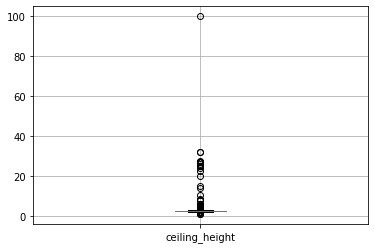

In [593]:
#На графике видно, что потолки высотой 100 метров - это очень выбивающееся значение
df.loc[:,['ceiling_height']].boxplot() 

In [594]:
#Посмотрим, сколько таких строк в нашем датасете
df.loc[:,['ceiling_height']].loc[df['ceiling_height']==100]

,ceiling_height
22869,100.00


In [595]:
#Аномально большое значение всего одно, мы не потеряем многого, если пометим его на удаление
bad_indexes.extend(df.loc[:,['ceiling_height']].loc[df['ceiling_height']==100].index)

<AxesSubplot:>

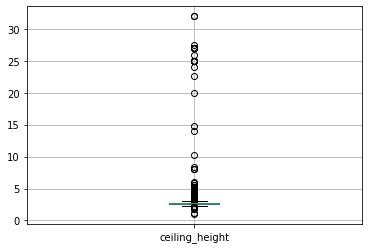

In [596]:
#Но даже без аномального значения, мы всё еще видим достаточно много верхних значений,
#не попадающих в 1,5 размера третьего квартиля (2.8*1.5 примерно 4.5 м)- это статистические выбросы.
df.loc[:,['ceiling_height']].loc[df['ceiling_height']!=100].boxplot() 

In [597]:
#Значения выше 20м достаточно редки, и можно предположить, что это просто ошибка ввода: пропущенная запятая
#Исправим данные, снизив разрядность таких данных на 1 знак:
df['ceiling_height'] = (df['ceiling_height']
                        .loc[df['ceiling_height']!=100]
                        .where(df['ceiling_height'] <= 20, (df['ceiling_height'] / 10)))

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

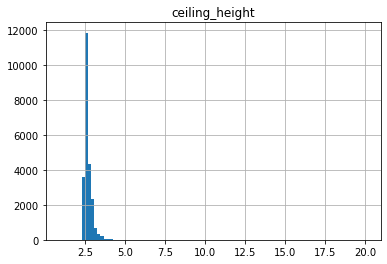

In [598]:
df.loc[:,['ceiling_height']].loc[df['ceiling_height']!=100].hist(bins=100)

In [599]:
#Значения меньше 2 или больше 4.5 метров редки и малоправдоподобны:
len(df.loc[:,['ceiling_height']].loc[(df['ceiling_height']<=2)|(df['ceiling_height']>=4.5)])


42

In [600]:
#Их также можно пометить на удаление
bad_indexes.extend(df.loc[:,['ceiling_height']].loc[(df['ceiling_height']<=2)|(df['ceiling_height']>=4.5)].index)

С другими столбцами, содержащими числовые значения,  обработка выбросов и аномалий будет сделана следующим образом:

1. Сначала будет произведена общая оценка: размах вариации, средние и медианные значения, разброс значений и границы квартилей.

2. Оценка также будет проведена визуально (графически).

3. Затем, ориентируясь на границы квартилей, будут определены статистические выбросы.

4. Граница отсечения выбросов будет откорректирована вручную, исходя из значимости потерь в данных в случае отсечения строк с выбросами из датасета, а также, временами из общих соображений и здравого смысла)

##### Столбец `total_area` (общая площадь квартиры)

In [601]:
df['total_area'].describe()

count   23699.00
mean       60.35
std        35.65
min        12.00
25%        40.00
50%        52.00
75%        69.90
max       900.00
Name: total_area, dtype: float64

<AxesSubplot:>

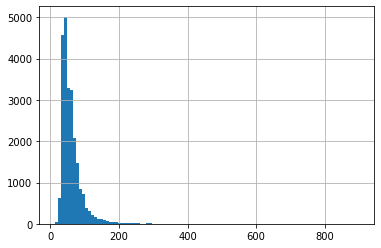

In [602]:
df['total_area'].hist(bins=100)

In [603]:
outrange = len(df['total_area'][df['total_area']>350])

In [604]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 41
Это несущественно



In [605]:
#Пометим их на удаление
bad_indexes.extend(df['total_area'][df['total_area']>350].index)

##### Столбец `living_area` (жилая площадь)

In [606]:
df['living_area'].describe()

count   23699.00
mean       34.62
std        22.38
min         2.00
25%        19.00
50%        30.00
75%        42.17
max       409.70
Name: living_area, dtype: float64

<AxesSubplot:>

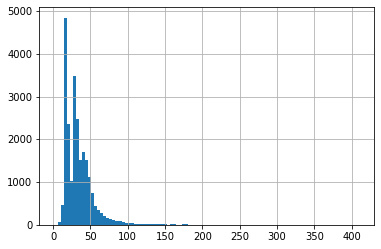

In [607]:
df['living_area'].hist(bins=100)

In [608]:
outrange = len(df['living_area'][df['living_area']>200])

In [609]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 43
Это несущественно



In [610]:
#Пометим их на удаление
bad_indexes.extend(df['living_area'][df['living_area']>200].index)

##### Столбец `kitchen_area` (площадь кухни)

In [611]:
df['kitchen_area'].describe()

count   23699.00
mean       10.51
std         6.04
min         1.30
25%         7.00
50%         9.00
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

<AxesSubplot:>

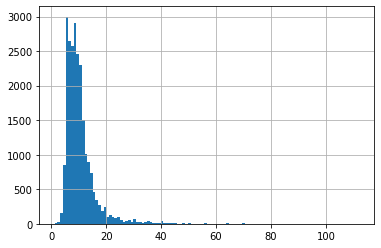

In [612]:
df['kitchen_area'].hist(bins=112)

In [613]:
outrange = len(df['kitchen_area'][df['kitchen_area']>50])

In [614]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 60
Это несущественно



In [615]:
#Пометим их на удаление
bad_indexes.extend(df['kitchen_area'][df['kitchen_area']>50].index)

##### Столбец `rooms` (количество комнат)

In [616]:
df['rooms'].describe()

count   23699.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

<AxesSubplot:>

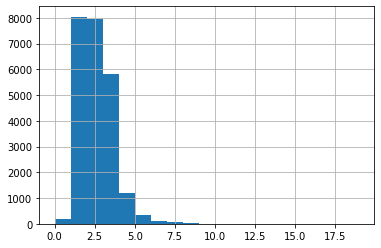

In [617]:
df['rooms'].hist(bins=19)

In [618]:
outrange = len(df['rooms'][df['rooms']>8])

In [619]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 19
Это несущественно



In [620]:
#Пометим их на удаление
bad_indexes.extend(df['rooms'][df['rooms']>8].index)

##### Столбец `balcony` (количество балконов)

In [621]:
df['balcony'].describe()

count   23699.00
mean        0.59
std         0.96
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         5.00
Name: balcony, dtype: float64

<AxesSubplot:>

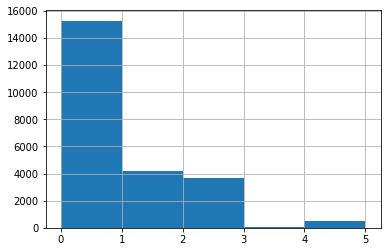

In [622]:
df['balcony'].hist(bins=5)

In [623]:
outrange = len(df['balcony'][df['balcony']>3])

Количество балконов разное в каждой планировке, основная масса приходится на квартиры без балконов, хотя встречаются квартиры и с 2 и с 3 балконами. Квартиры с большим количеством балконов - редкость.

In [624]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 487
Это приемлимо



Однако, хотя удаление всех объявлений о продаже с количеством балконов больше трех было бы приемлимо (менее 5% от общего количества строк датасета), однако эта информация не настолько существенна для нашего анализа, чтобы потерять из-за нее такой объем данных. Поэтому, эти записи решено оставить.

##### Столбец `floor` (этаж квартиры)

In [625]:
df['floor'].describe()

count   23699.00
mean        5.89
std         4.89
min         1.00
25%         2.00
50%         4.00
75%         8.00
max        33.00
Name: floor, dtype: float64

<AxesSubplot:>

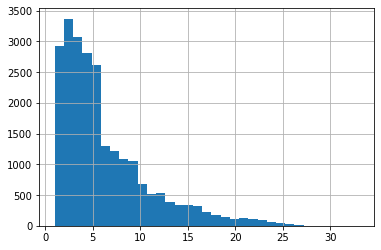

In [626]:
df['floor'].hist(bins=33)

In [627]:
#Проверим, сколько объявлений очень дорогой недвижимости в нашем датасете:
outrange = len(df['floor'][df['floor']>30])

In [628]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 3
Это несущественно



In [629]:
#Пометим их на удаление
bad_indexes.extend(df['floor'][df['floor']>30].index)

##### Столбец `floors_total` (общее количество этажей в доме)

In [630]:
df['floors_total'].describe()

count   23613.00
mean       10.67
std         6.60
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

<AxesSubplot:>

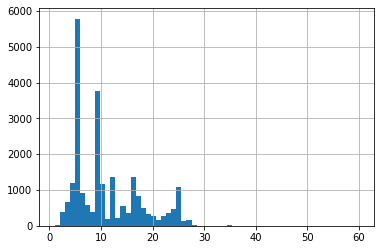

In [631]:
df['floors_total'].hist(bins=60)

In [632]:
#Проверим, сколько объявлений очень дорогой недвижимости в нашем датасете:
outrange = len(df['floors_total'][df['floors_total']>30])

In [633]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 32
Это несущественно



In [634]:
#Пометим их на удаление
bad_indexes.extend(df['floors_total'][df['floors_total']>30].index)

##### Столбец `last_price` (цена объекта)

In [635]:
df['last_price'].describe()

count       23699.00
mean      6541548.77
std      10887013.27
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
max     763000000.00
Name: last_price, dtype: float64

<AxesSubplot:>

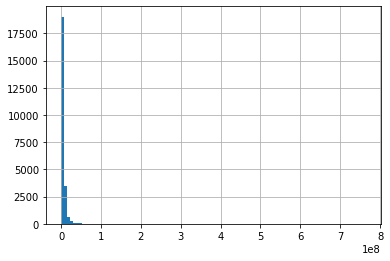

In [636]:
df['last_price'].hist(bins=100)

Наверное, цена - это очень индивидуальная и, иногда, очень субъективная характеристика. Поэтому, здесь вряд ли подойдут какие-то типовые рекомендации, наподобие модели "ящика с усами".
Наверное, единственное, что здесь стоит сделать - избавиться от очень дорогой элитной недвижимости (более 50 млн.руб.). Эти объявления наверняка носят "штучный" характер и искажают общую картину статистическими "выбросами" (причем не только по цене, но, скорее всего, и по другим характеристикам: площадь, количество балконов и проч.).

In [637]:
#Проверим, сколько объявлений очень дорогой недвижимости в нашем датасете:
outrange = len(df['last_price'][df['last_price']>50000000])

In [638]:
#Как повлияет удаление выбранного количества строк на результатах анализа?
print('Будет помечено "на удаление" строк:', outrange)
checklost(outrange)

Будет помечено "на удаление" строк: 131
Это несущественно



In [639]:
#Пометим их на удаление
bad_indexes.extend(df['last_price'][df['last_price']>50000000].index)

#### Общие результаты проведенной предобработки данных

Проверим, сколько всего строк мы собираемся удалить из датафрейма по результатам предобработки:

In [640]:
print('Всего помечено "на удаление" строк:', len(pd.Series(bad_indexes).unique()))
checklost(len(pd.Series(bad_indexes).unique()))

Всего помечено "на удаление" строк: 413
Это несущественно



Как мы видим, количество помеченных строк незначительно. Однако избавившись от них, мы значительно повысим качество данных для анализа. Итоговый датафрейм будет очищен от статистических выбросов, аномалий и пропущенных значений.

Запишем датафрейм с удаленными в результате предобработки строками, в переменную `data`. Исходный датафрейм `df` приведем к изначальному виду. Это позволит нам при необходимости обращаться к сравнению данных до и после предобработки, чтобы оценить качество проделанной работы по предобработке данных.

In [641]:
data = df
data.drop(labels = bad_indexes, axis = 0, inplace = True)
#Сбрасываем индексы в датафрейме (исходные индексы запишем в отдельный столбец):
data.reset_index(drop=False, inplace=True)
#Перезапишем исходный датафрейм для сравнения:
df = pd.read_csv(dataset, sep='\t')
#Столбец с количеством фотографий в дальнейшем анализе нам не понадобится. Он лишний - удалим его:
df = df.drop(['total_images'], axis='columns')
data = data.drop(['total_images'], axis='columns')
#На предобработке изменение типа данных не сработало, из-за наличия пропусков в столбце 'floors_total'.
#В постобработанном датафрейме пропусков нет.
#Посмотрим, сработает ли теперь:
data['floors_total'] =  data['floors_total'].astype('int')

In [642]:
#Посмотрим еще (после удаления) раз на типы данных в столбцах нашего датафрейма:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23286 entries, 0 to 23285
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 23286 non-null  int64         
 1   last_price            23286 non-null  float64       
 2   total_area            23286 non-null  float64       
 3   first_day_exposition  23286 non-null  datetime64[ns]
 4   rooms                 23286 non-null  int64         
 5   ceiling_height        23286 non-null  float64       
 6   floors_total          23286 non-null  int64         
 7   living_area           23286 non-null  float64       
 8   floor                 23286 non-null  int64         
 9   is_apartment          23286 non-null  bool          
 10  studio                23286 non-null  bool          
 11  open_plan             23286 non-null  bool          
 12  kitchen_area          23286 non-null  float64       
 13  balcony         

Как мы видим, из датафрейма исчезло 413 строк (как и планировалось), что составляет меньше 2% от общего количества строк. 

Типы данных во всех столбцах соответствуют содержащейся в них информации.

Проверим, не осталось ли в датафрейме пропущенных значений:

In [643]:
#Посмотрим, в каких столбцах датафрейма есть пропуски и оценим их количество, абсолютное и относительное:
n = 0
for column in data.columns:
    if data[column].isna().sum() > 0:
        na = data[column].isna().sum()
        print('%-25s %-20s %-20.3f' % (data.columns[n], f'isna() {na}', (100*na/len(data))))
    n += 1

airports_nearest          isna() 5483          23.546              
city_centers_nearest      isna() 5483          23.546              
parks_around3000          isna() 5483          23.546              
parks_nearest             isna() 15430         66.263              
ponds_around3000          isna() 5483          23.546              
ponds_nearest             isna() 14441         62.016              


Пропуски остались, но только в столбцах с геолокацией, которые мы оставили незатронутыми предобработкой.

### Посчитаем и добавим в таблицу новые столбцы

#### Цена одного квадратного метра

In [644]:
#Поделим цену на площадь, и запишем полученные значения в новый столбец датафрейма с данными:
data['price_m2'] = data['last_price'] / data['total_area'] /1000
data['price_m2'].describe()

count   23286.00
mean       97.42
std        39.34
min         0.11
25%        76.39
50%        94.74
75%       113.64
max       848.48
Name: price_m2, dtype: float64

In [645]:
#Сделаем то же для исходного датафрейма:
df['price_m2'] = df['last_price'] / df['total_area'] /1000
df['price_m2'].describe()

count   23699.00
mean       99.42
std        50.31
min         0.11
25%        76.59
50%        95.00
75%       114.26
max      1907.50
Name: price_m2, dtype: float64

#### День недели публикации объявления

In [646]:
#Добавим в датафрейм с данными столбец с днями недели:
data['weekday'] = data['first_day_exposition'].dt.weekday
sorted(data['weekday'].unique())

[0, 1, 2, 3, 4, 5, 6]

In [647]:
#Сделаем то же для исходного датафрейма:
df['weekday'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.weekday
sorted(df['weekday'].unique())

[0, 1, 2, 3, 4, 5, 6]

#### Месяц публикации объявления

In [648]:
#Добавим в датафрейм с данными столбец с днями недели:
data['month'] = data['first_day_exposition'].dt.month
sorted(data['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [649]:
#Сделаем то же для исходного датафрейма:
df['month'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.month
sorted(df['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Год публикации объявления

In [650]:
data['year'] = data['first_day_exposition'].dt.year
sorted(data['year'].unique())

[2014, 2015, 2016, 2017, 2018, 2019]

In [651]:
df['year'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.year
sorted(df['year'].unique())

[2014, 2015, 2016, 2017, 2018, 2019]

#### Тип этажа квартиры

Пройдемся циклом по датафрейму с данными, и заполним тип этажа квартиры:

In [652]:
#Создаем пустой список:
floor_type = []
#Наполняем список категориальными значениями будущего столбца:
for index in range(data['floor'].count()):
    if data['floor'][index] == 1:
        floor_type.append('первый')
    elif data['floor'][index] == data['floors_total'][index]:
        floor_type.append('последний')
    else:
        floor_type.append('другой')

#Добавляем столбец в датафрейм:
data.insert(9, 'floor_type', floor_type, False)

In [653]:
#Проверим результат:
data.loc[:13,['floor_type','floor','floors_total']]

,floor_type,floor,floors_total
0,другой,8,16
1,первый,1,11
2,другой,4,5
3,другой,13,14
4,другой,5,12
5,другой,6,26
6,другой,22,24
7,другой,26,27
8,другой,7,9
9,другой,3,12


Заполним тип этажа квартиры в исходном датафрейме:

In [654]:
#Создаем пустой список:
floor_type = []
#Наполняем список категориальными значениями будущего столбца:
for index in range(df['floor'].count()):
    if df['floor'][index] == 1:
        floor_type.append('первый')
    elif df['floor'][index] == df['floors_total'][index]:
        floor_type.append('последний')
    else:
        floor_type.append('другой')

#Добавляем столбец в датафрейм:
df.insert(9, 'floor_type', floor_type, False)

In [655]:
#Проверим результат:
df.loc[:13,['floor_type','floor','floors_total']]

,floor_type,floor,floors_total
0,другой,8,16.00
1,первый,1,11.00
2,другой,4,5.00
3,другой,9,14.00
4,другой,13,14.00
5,другой,5,12.00
6,другой,6,26.00
7,другой,22,24.00
8,другой,26,27.00
9,другой,7,9.00


#### Расстояние до центра города в километрах

In [656]:
#Добавим в датафрейм новый столбец с расстоянием до центра города в км:
data.insert(18, 'city_centers_nearest_km', round((data['city_centers_nearest'] / 1000),0), False)

In [657]:
#Проверим результат:
data.loc[:5,['city_centers_nearest_km','city_centers_nearest']]

,city_centers_nearest_km,city_centers_nearest
0,16.00,16028.00
1,19.00,18603.00
2,14.00,13933.00
3,8.00,8098.00
4,NaN,NaN
5,19.00,19143.00


In [658]:
#Добавим в датафрейм новый столбец с расстоянием до центра города в км:
df.insert(18, 'city_centers_nearest_km', round((df['cityCenters_nearest'] / 1000),0), False)
#Проверим результат:
df.loc[:5,['city_centers_nearest_km','cityCenters_nearest']]

,city_centers_nearest_km,cityCenters_nearest
0,16.00,16028.00
1,19.00,18603.00
2,14.00,13933.00
3,7.00,6800.00
4,8.00,8098.00
5,NaN,NaN


### Исследовательский анализ данных

#### Исследуем основные параметры объектов

In [699]:
#Создадим столбец-счетчик (вспомогательный столбец для расчетов)
data['count'] = 1

In [729]:
#Поделим все квартиры по ценовым категориям от 1 до 10, где 1 - очень дешевые, а 10 - очень дорогие квартиры
data['price_type'] = pd.qcut(data['last_price'], q=10, labels=[1,2,3,4,5,6,7,8,9,10], precision=0, duplicates='drop')

plt.show()
.pivot_table(index='price_type', values='', aggfunc='mean').plot()
.plot(style='-')
.sort_values(by='total_area',ascending=False)
.reset_index(inplace=True)


##### Столбец 'total_area', общая площадь

<AxesSubplot:ylabel='Frequency'>

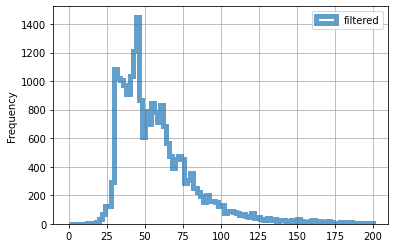

In [738]:
data.plot(
    kind='hist',
    y='total_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='filtered',
    grid=True,
    legend=True,
) 

Большинство квартир на рынке недвижимости имеют площадь в пределах от 30 до 80 кв.м.

##### Столбец 'living_area', жилая площадь

<AxesSubplot:ylabel='Frequency'>

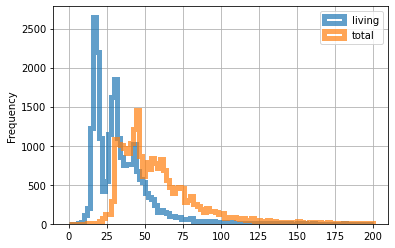

In [742]:
ax = data.plot(
    kind='hist',
    y='living_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='living',
)
data.plot(
    kind='hist',
    y='total_area',
    histtype='step',
    range=(0, 200),
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='total',
    ax=ax,
    grid=True,
    legend=True,
) 

Кривая диаграммы жилой площади повторяет по форме диаграмму общей площади, но смещена влево (что логично, поскольку жилая площадь меньше общей площади)

##### Столбец 'kitchen_area', площадь кухни

<AxesSubplot:xlabel='price_type'>

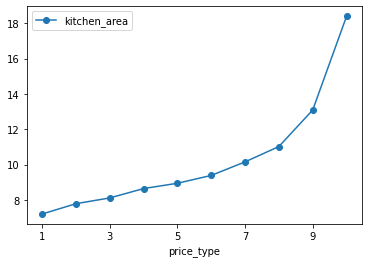

In [745]:
data.pivot_table(index='price_type', values='kitchen_area', aggfunc='mean').plot(style='o-')

In [746]:
data['kitchen_area'].mean()

10.258679979386756

При средней площади кухни в 10 метров, только самые топовые по цене объекты недвижимости могут похвастаться кухней больше 10 м.
Лишь у 10% кухня приближается по размеру к 20 м2. И, как правило, даже в среднем ценовом сегменте не превышает этот порог.

##### Столбец 'last_price', цена объекта

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

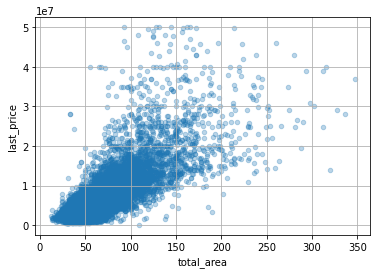

In [748]:
(data.plot(
           x='total_area', 
           y='last_price', 
           kind='scatter', 
           grid=True, 
           alpha=0.3))

Цена объекта недвижимости тесно связана с его общей площадью, однако по мере увеличения этих параметров взаимосвязь между ними существенно слабеет.

##### Столбец 'rooms', количество комнат

<AxesSubplot:xlabel='rooms'>

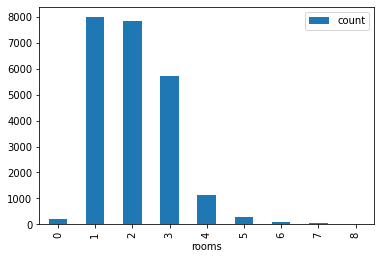

In [755]:
data.pivot_table(index='rooms', values='count', aggfunc='count').plot(kind='bar')

Большая часть планировок имеет 1,2,3 реже 4 комнаты. В сумме данные планировки занимают около 90% рынка.

<AxesSubplot:ylabel='count'>

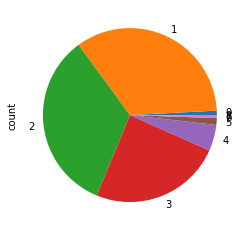

In [754]:
#data.pivot_table(index='rooms', values='count', aggfunc='count').plot(kind='bar')
data.groupby('rooms')['count'].count().plot(kind='pie')

##### Столбец 'ceiling_height', высота потолков

<AxesSubplot:>

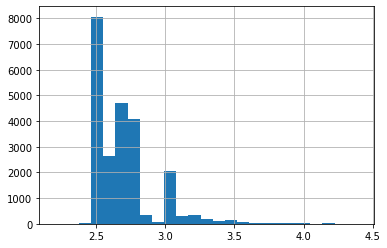

In [759]:
data['ceiling_height'].hist(bins=25)

Подавляющее большинство планировок имеет высоту потолков 2,5 м. Впрочем, 2,7 - 2,8 м тоже встречается довольно часто. Отличительной особенностью Петербурга является старая застройка, с потолками выше 3 м.

##### Столбец 'floor', этаж квартиры

<AxesSubplot:xlabel='floors_total', ylabel='floor'>

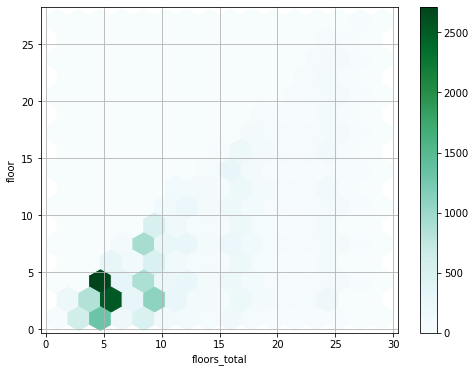

In [774]:
data.plot(x='floors_total', y='floor', kind='hexbin', gridsize=15, figsize=(8, 6), sharex=False, grid=True) 

Чаще всего к продаже предлагаются 4-5 этажи пятиэтажных зданий.

##### Столбец 'floor_type', тип этажа квартиры

<AxesSubplot:xlabel='floor_type'>

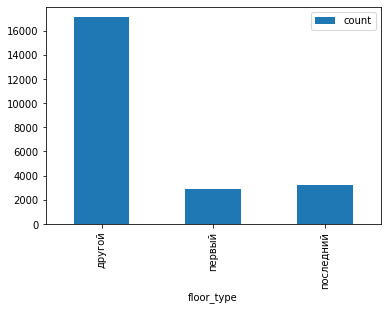

In [776]:
data.pivot_table(index='floor_type', values='count', aggfunc='count').plot(kind='bar')

Первый и последний этажи состовляют примерно по 10% от общего объема предложения на рынке недвижимости каждый.

##### Столбец 'floors_total', общее количество этажей в доме

<AxesSubplot:>

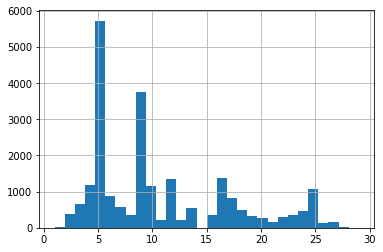

In [779]:
data['floors_total'].hist(bins=30)

В основном на рынке преобладают серии домов с 5-ти и 9-ти этажной застройкой.

##### Столбец 'city_centers_nearest', расстояние до центра города в метрах

<AxesSubplot:xlabel='price_type'>

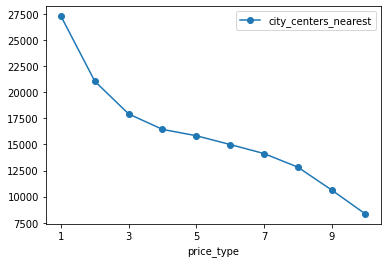

In [780]:
data.pivot_table(index='price_type', values='city_centers_nearest', aggfunc='mean').plot(style='o-')

Самое дешевое жилье - максимально далеко от центра города. И наоборот.
При этом на среднеудаленном от центра города расстоянии зависимость между ценой и расстоянием от центра ослабевает.

##### Столбец 'airports_nearest', расстояние до ближайшего аэропорта

<AxesSubplot:xlabel='price_type'>

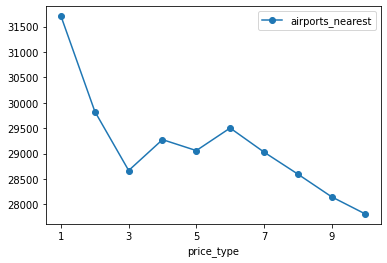

In [781]:
data.pivot_table(index='price_type', values='airports_nearest', aggfunc='mean').plot(style='o-')

Аналогичная картина и с расстоянием до ближайшего аэропорта.

##### Столбец 'parks_nearest', расстояние до ближайшего парка

<AxesSubplot:xlabel='price_type'>

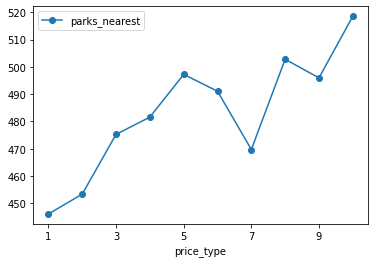

In [782]:
data.pivot_table(index='price_type', values='parks_nearest', aggfunc='mean').plot(style='o-')

А вот с расстоянием до парковых зон - картина прямо противоположная. Оно и понятно - чем дальше от центра города, тем больше парковых зон.

##### Столбец 'weekday', день публикации объявления

<AxesSubplot:>

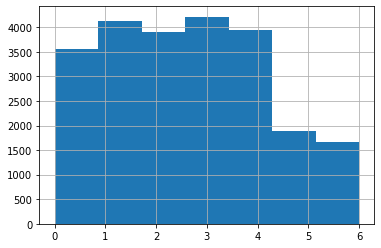

In [786]:
data['weekday'].hist(bins=7)

Как правило, объявления люди размещают в будние дни.

##### Столбец 'month', месяц публикации объявления

<AxesSubplot:>

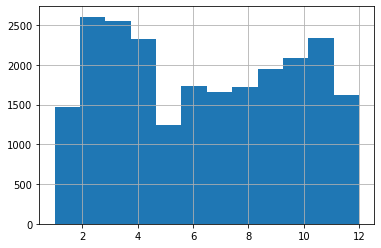

In [785]:
data['month'].hist(bins=12)

В преддверии и сразу после начала года люди реже размещают объявления. Также определенный спад прослеживается в летние месяцы.

#### Как быстро продавались квартиры?

На этапе предобработке отсутсвующие значения столбца 'days_exposition' были заменены на 0.

Для анализа скорости продажи квартир создадим вспомогательный датафрейм, в котором будут только те объекты недвижимости, в которых есть информация в столбце 'days_exposition' (предположительно, это объекты, продажа которых завершена).

In [662]:
data_sold = data.loc[data['days_exposition']!=0]

In [663]:
#Посмотрим общую информацию о продолжительности продаж квартир:
data_sold['days_exposition'].describe()

count   20175.00
mean      179.86
std       219.08
min         1.00
25%        45.00
50%        95.00
75%       229.00
max      1580.00
Name: days_exposition, dtype: float64

In [664]:
#Посчитаем медиану
data_sold['days_exposition'].median()

95.0

In [665]:
#И среднее
data_sold['days_exposition'].mean()

179.86413878562578

<AxesSubplot:>

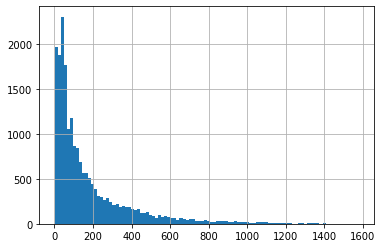

In [666]:
#Посмотрим форму распределения данных в столбце 'days_exposition'
data_sold['days_exposition'].hist(bins=100)

На первый взгляд, форма распределения похожа на типичное распределение Пуассона.

<AxesSubplot:>

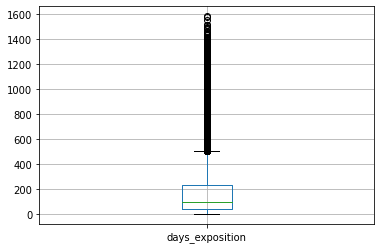

In [667]:
#Посмотрим "ящик с усами" для столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].boxplot() 

<AxesSubplot:>

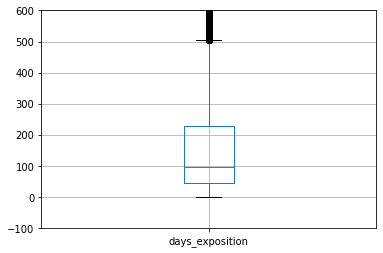

In [668]:
#Посмотрим "ящик с усами" для столбца 'days_exposition' в чуть более увеличенном масштабе:
plt.ylim(-100, 600)
data_sold.loc[:,['days_exposition']].boxplot() 

Нижний "ус" отсекает множество на уровне нуля. Это означает, что нижняя граница скорости продаж вписывается в нормальные значения. Что же касается верхней границы - всё, что касается продаж чуть выше 500 дней, является статистическими выбросами. Это "ненормальная" продолжительность продаж, и для выводов о "нормальной" продолжительности продаж такие случаи нам не нужны. От них лучше избавиться.

Сформулируем верхнюю границу выбросов чуть менее радикально. Скажем так: квартиры, которые продаются на рынке более полутора лет, являются скорее существенным отклонением от нормы по скорости продаж.

In [669]:
#Посмотрим, сколько таких квартир:
print(len(data_sold.loc[data['days_exposition']>365*1.5]),' из ', len(data_sold))

1454  из  20175


Долгопродающиеся квартиры - это около 7% от общей массы объявлений. Довольно существенная доля, однако влияние на качество анализа, которое данные объекты оказывают, скорее отрицательное. Они сильно искажают на статистические показатели скорости продаж. Удалим их.

In [670]:
data_sold = data_sold.loc[data['days_exposition']<365*1.5]

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

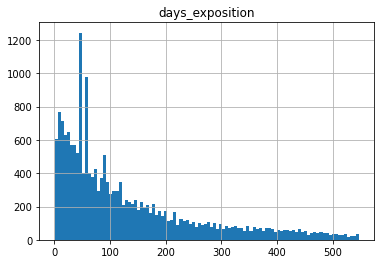

In [671]:
#Посмотрим теперь на гистограмму столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].hist(bins=100)

На гистограмме есть несколько пиков, которые явно выбиваются из общего тренда. Неплохо было бы посмотреть, какие сроки продажи являются фаворитами по количеству повторений.

In [672]:
data_sold['days_exposition'].value_counts().head(10)

45    875
60    537
7     232
30    207
90    192
4     174
3     156
5     148
14    143
9     141
Name: days_exposition, dtype: int64

Вот это неожиданность! Наиболее частая продолжительность продаж носит слишком уж системный характер: неделя, месяц, полтора/два/три месяца. Судя по всему, это не продолжительность продажи, а некоторые сроки, в которые объявление должно было быть снято или продлено. В этот же ряд попадает, скорее всего, продолжительность продаж в 14 дней (две недели). Если это действительно так, то строки с данной продолжительностью продаж искажают информацию о реальной продолжительности размещения объявления до момента продажи. Почистим наш датасет от таких строк.

In [673]:
data_sold = data_sold.query('days_exposition not in [7,14,30,45,60,90]')

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

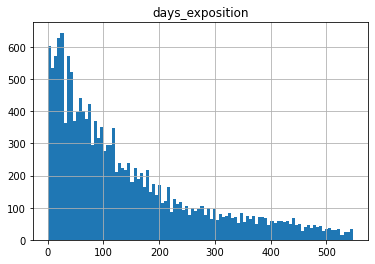

In [674]:
#Посмотрим теперь на гистограмму столбца 'days_exposition'
data_sold.loc[:,['days_exposition']].hist(bins=100)

Мы очистили наши данные от случайны и систематических ошибок и статистических выбросов и аномалий. Разобъем наш датасет на три равные части по вариативности сроков продаж:

In [675]:
data_sold['days_exposition_type'] = pd.qcut(data_sold['days_exposition'], q=3, labels=['быстро','нормально','медленно'], precision=0, duplicates='drop')

In [676]:
data_sold.pivot_table(index='days_exposition_type', values='days_exposition', aggfunc='max')

,days_exposition
days_exposition_type,
быстро,59
нормально,161
медленно,547


**Вывод:** Рынок недвижимости - весьма консервативный. Продажа квартиры в течении двух месяцев считается быстрой; нормальной продолжительностью продажи является срок от двух до шести месяцев; от полугода до полутора лет - долго, но в пределах нормы. Однако не не редки случаи, когда объект недвижимости продается и более полутора лет. Такие случаи на рынке недвижимости являются отклонением от общего правила, но также встречаются на практике.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Для анализа влияния факторов на цену объекта недвижимости, построим матрицу диаграмм рассеяния для каждого из факторов, чтобы визуально оценить наличие связи между ценой и каждым из факторов (первый столбец матрицы).

In [696]:
#Запишем перечень факторов в переменную `list`.
#Первой укажем цену, тогда первый столбец матрицы покажет нам цависимость цены от каждого из факторов.
list=(['last_price',# цена объекта
       'total_area',# общая площадь
       'living_area',# жилая площадь
       'kitchen_area',# площадь кухни
       'rooms',# количество комнат
       'floor_type',# тип этажа квартиры
       'weekday',# день публикации объявления
       'month',# месяц публикации объявления
       'year'# месяц публикации объявления
      ])

array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='living_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='weekday', ylabel='last_price'>,
        <AxesSubplot:xlabel='month', ylabel='last_price'>,
        <AxesSubplot:xlabel='year', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='living_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='weekday', ylabel='total_area'>,
        <AxesSubplot:xlabel='month', ylabel='total_area'>,
        <AxesSubplot:xlabel='year', ylabel='total_area'>],
      

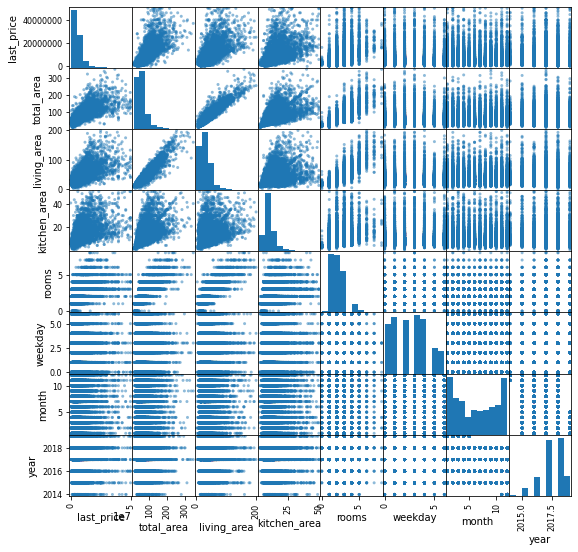

In [694]:
pd.plotting.scatter_matrix(data.loc[:,list], figsize=(9, 9))

Также построим матрицу коэффициентов корреляции, для каждого из параметров:

In [695]:
data.loc[:,list].corr()

,last_price,total_area,living_area,kitchen_area,rooms,weekday,month,year
last_price,1.00,0.78,0.69,0.62,0.50,-0.02,0.01,-0.05
total_area,0.78,1.00,0.94,0.62,0.79,-0.01,0.01,-0.08
living_area,0.69,0.94,1.00,0.42,0.86,-0.01,0.00,-0.07
kitchen_area,0.62,0.62,0.42,1.00,0.29,-0.01,0.01,-0.06
rooms,0.50,0.79,0.86,0.29,1.00,-0.01,-0.00,-0.05
weekday,-0.02,-0.01,-0.01,-0.01,-0.01,1.00,0.01,-0.00
month,0.01,0.01,0.00,0.01,-0.00,0.01,1.00,-0.27
year,-0.05,-0.08,-0.07,-0.06,-0.05,-0.00,-0.27,1.00


**Вывод:** Как видно из приведенных выше данных, первые три фактора (общая площадь, жилая площадь, площадь кухни) оказывают значительное влияние на цену. Общая и жилая площадь, помимо этого, тесно связаны между собой (что вполне логично).

Количество комнат также оказывает влияние на цену, хотя заметно менее существенное.

Скорее, результаты анализа следует интерпретировать следующим образом:

На цену объекта недвижимости оказывает существенное влияние его общая площадь. Влияние, которое оказывают прочие характеристики объекта недвижимости (жилая площадь, площадь кухни, количество комнат) является следствием того, что между данными факторами и общей площадью существует прямая корреляция, а поэтому они показывают также корреляцию и с ценой.

В то же время, и графически и через коэфициент Пирсона видно, что влияние дня недели или месяца размещения объявления на цену находится в пределах статистической погрешности.

Влияние года размещения объявления на цену чуть выше чем уровень погрешности, и может отражать вклад долгосрочных факторов (инфляции, фазы экономического цикла, бум или спад на рынке недвижимости) в формирование цен на рынке недвижимости.



#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [677]:
#Сначала отберем 10 населенных пунктов с наибольшим числом объявлений, и запишем список в переменную top_10:
top_10 = data['locality_name'].value_counts().index[0:10]
top_10

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'поселок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'поселок Парголово', 'Гатчина', 'Выборг'],
      dtype='object')

In [678]:
#Посмотрим среднюю цену в каждом из населенных пунктов списка из Топ-10:
(data
     .query('locality_name in @top_10')
     .pivot_table(index='locality_name', values='price_m2', aggfunc='mean')
     .sort_values(by='price_m2',ascending=False))

,price_m2
locality_name,
Санкт-Петербург,112.09
Пушкин,102.87
Кудрово,95.26
поселок Парголово,90.18
Мурино,86.04
поселок Шушары,78.55
Колпино,75.42
Гатчина,68.75
Всеволожск,68.72


Определим самую высокую и самую низкую цену квадратного метра, усредненную по каждому населенному пункту:

In [679]:
min_price = data.groupby('locality_name')['price_m2'].mean().min()
max_price = data.groupby('locality_name')['price_m2'].mean().max()

Посмотрим, в каком населенном пункте самые низкие цены на недвижимость:

In [680]:
data.pivot_table(index='locality_name', values='price_m2', aggfunc='mean').query('price_m2 == @min_price')

,price_m2
locality_name,
деревня Старополье,11.21


Посмотрим, в каком населенном пункте самые высокие цены на недвижимость:

In [681]:
data.pivot_table(index='locality_name', values='price_m2', aggfunc='mean').query('price_m2 == @max_price')

,price_m2
locality_name,
Зеленогорск,115.12


**Вывод:** 

#### Квартиры в Санкт-Петербурге

<AxesSubplot:xlabel='city_centers_nearest_km', ylabel='price_m2'>

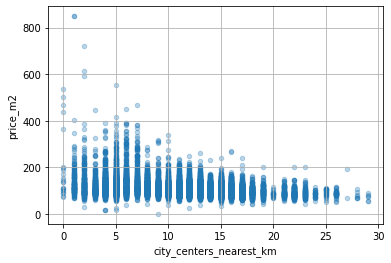

In [682]:
#Построим сначала диаграмму рассеяния для цены квадратного метра в Петербурге в зависимости от расстояния от центра города:
(data[data['locality_name'] == 'Санкт-Петербург']
       .plot(
           x='city_centers_nearest_km', 
           y='price_m2', 
           kind='scatter', 
           grid=True, 
           alpha=0.3))

<AxesSubplot:xlabel='km'>

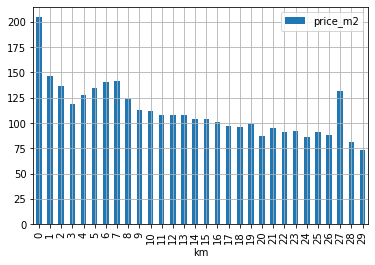

In [683]:
#А затем столбчатую диаграмму со значением средней цены для каждого из километра:
SPb = (data[data['locality_name'] == 'Санкт-Петербург']
       .pivot_table(index='city_centers_nearest_km', values='price_m2', aggfunc='mean'))
SPb['km'] = SPb.index.astype('int')
SPb.plot( x='km', y='price_m2', kind='bar', grid=True)

In [684]:
print(SPb['km'].corr(SPb['price_m2']))

-0.7851700536463906


Зависимость цены квадратного метра от расстояния от центра города прослеживается на графике довольно явно, и коэфициент Пирсона это подтверждает.

Если устранить выбросы, которые в определенном количестве есть на каждом километре, зависимость будет по всей видимости еще более явной. 

Резкий всплеск на 27 километре связан с малым количеством наблюдений, из которых одно является, по всей видимости, аномально высоким для данного участка.

Чтобы показать закономерность более явно, обобщим информацию о средней цене квадратного метро для более широких групп:
- от 0 до 10 км;
- от 10 до 20 км;
- от 20 до 30 км.

In [685]:
#Создаем пустой список:
km_group = []

#Наполняем список категориальными значениями будущего столбца:
for index in range(len(data)):
    if data['city_centers_nearest_km'][index] <= 10:
        km_group.append('от 0 до 10 км')
    elif data['city_centers_nearest_km'][index] <= 20:
        km_group.append('от 10 до 20 км')
    else:
        km_group.append('от 20 до 30 км')

#Добавляем столбец в датафрейм:
data.insert(18,'city_centers_nearest_km_group', km_group, False)
data[data['locality_name'] == 'Санкт-Петербург'].groupby('city_centers_nearest_km_group')['price_m2'].mean()

city_centers_nearest_km_group
от 0 до 10 км    128.00
от 10 до 20 км   104.30
от 20 до 30 км    96.92
Name: price_m2, dtype: float64

<AxesSubplot:xlabel='city_centers_nearest_km_group'>

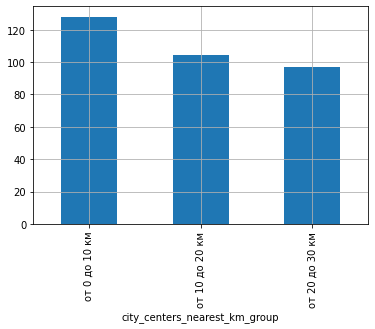

In [686]:
data[data['locality_name'] == 'Санкт-Петербург']\
.groupby('city_centers_nearest_km_group')['price_m2']\
.mean()\
.plot( x='km', y='price_m2', kind='bar', grid=True)

Как видно из графика, каждые дополнительные 10 км о центра города неизменно снижают среднюю цену квадратного метра.

**Вывод:** Анализ влияния удаленности от центра города на стоимость недвижимости на примере Санкт-Петербурга показал, что это влияние довольно существенное (корреляция на уровне 80 %), и по мере удаленности от центра города цена квадратного метра недвижимости падает довольно значительно. Эта тенденция особенно заметна вбизи центра, и сохраняется по мере удаления. Однако темпы падения цены квадратного метра по мере удаления от центра замедляются, что говорит о нелинейном характере этой зависимости.

### Общий вывод

Мы узнали очень много о рынке недвижимости, провели предобработку данных и построили тысячу графиков по данным, полученным в результате.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод